In [11]:
from DataManager import CALFData, collateGCN
import numpy as np
import torch 
from Model import ContextAwareModel
from loss import ContextAwareLoss, SpottingLoss
from train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt

# Model 1

In [ ]:
@dataclass
class Args:
    receptive_field = 20
    framerate = 5
    chunks_per_epoch = 1824
    class_split = "alive"
    num_detections = 200
    chunk_size = 60
    batch_size = 32
    input_channel = 10

    backbone_feature = None
    backbone_player = "GCN"
    tiny=None

    max_epochs=100
    load_weights=None
    model_name="Testing_Model"
    mode=0
    test_only=False
    challenge=True
    teacher=False
    K_params=None
    num_features=512
    evaluation_frequency=20
    dim_capsule=16
    lambda_coord=5.0
    lambda_noobj=0.5
    loss_weight_segmentation=0.005
    loss_weight_detection=1.0
    feature_multiplier=1
    calibration=False
    calibration_field=False
    calibration_cone=False
    calibration_confidence=False
    dim_representation_w=64
    dim_representation_h=32
    dim_representation_c=3
    dim_representation_player=2
    dist_graph_player=25
    with_dropout=0.0
    LR=1e-03
    patience=25
    GPU=0 
    max_num_worker=1
    loglevel='INFO'

In [ ]:
args = Args
collate_fn = collateGCN

train_dataset = CALFData(split="train", args=args)
validation_dataset = CALFData(split="validate", args=args)

train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

labels, targets, representations = next(iter(train_loader))

model = ContextAwareModel(num_classes=2, args=args)
criterion_segmentation = ContextAwareLoss(K=train_dataset.K_parameters)
criterion_spotting = SpottingLoss(lambda_coord=args.lambda_coord, lambda_noobj=args.lambda_noobj)
optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                            betas=(0.9, 0.999), eps=1e-07, 
                            weight_decay=0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

losses = trainer(train_loader, validate_loader,
                    model, optimizer, scheduler, 
                    [criterion_segmentation, criterion_spotting], 
                    [args.loss_weight_segmentation, args.loss_weight_detection],
                    model_name=args.model_name,
                    max_epochs=args.max_epochs, evaluation_frequency=args.evaluation_frequency)

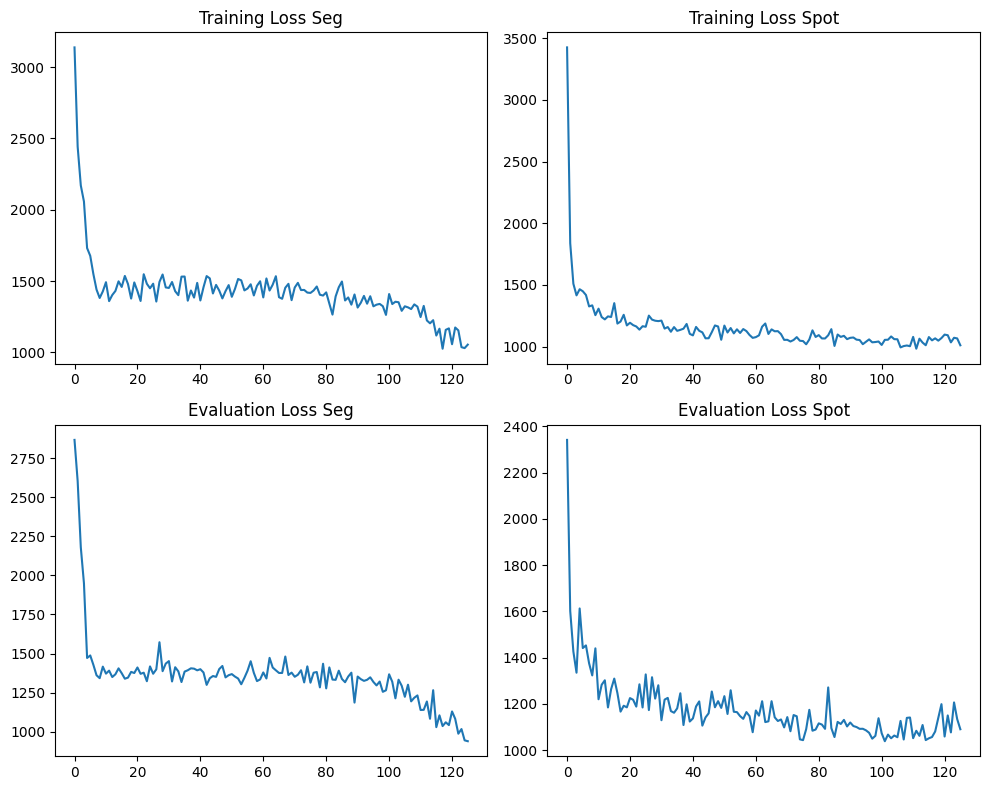

In [17]:
paths = ["train_loss_seg.pkl","train_loss_spot.pkl","eval_loss_seg.pkl","eval_loss_spot.pkl"]
names = ["Training Loss Seg", "Training Loss Spot", "Evaluation Loss Seg", "Evaluation Loss Spot"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Loop through each subplot
for i, ax in enumerate(axes.flatten()):
    # Read files 
    with open("results/"+paths[i], 'rb') as pickle_file:
        results = pickle.load(pickle_file)
    # Plot the corresponding data
    ax.plot(results)
    ax.set_title(names[i])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()